In [41]:
%matplotlib inline

In [42]:
import numpy as np
from numba import cuda
from PIL import Image
import sys
import os
from pathlib import Path


def get_local_folder():
    return Path.cwd()


stdout = sys.stdout

DATA_PATH = get_local_folder().parent.parent / 'data'


# load example image from pillow
# img = Image.fromarray(np.random.randint(0, 255, (12, 12, 3), dtype=np.uint8))
# 
def load_image():
    img = Image.open(DATA_PATH / 'img.jpg')
    # convert to rgb
    img = img.convert('RGB')

    return np.array(img, dtype=np.float32)


In [43]:
def gkern(l=5, sig=1.):
    """\
    creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)


# create a gaussian kernel
KERNEL_SIZE = 64
kernel = gkern(KERNEL_SIZE, 50)

In [44]:
from numba import float32


# apply a convolution filter
@cuda.jit()
def convolve_single_channel(result, mask, image):
    # expects a 2D grid and 2D blocks,
    # a grayscale image with 1 channel.

    # (-2-) 2D coordinates of the current thread:
    i, j = cuda.grid(2)

    # (-3-) if the thread coordinates are outside of the image, we ignore the thread:
    image_rows, image_cols = image.shape
    if (i >= image_rows) or (j >= image_cols):
        return

    # (-4-) initialize the result for the current pixel:
    result[i, j] = 0

    delta = mask.shape[0] // 2

    # (-5-) iterate over the mask:
    for x in range(-delta, delta + 1):
        for y in range(-delta, delta + 1):
            if i + x >= 0 and i + x < image_rows and j + y >= 0 and j + y < image_cols:
                result[i, j] += image[i + x, j + y] * mask[x + delta, y + delta]


@cuda.jit
def convolve_multi_channel(result, mask, image):
    # expects a 2D grid and 2D blocks,
    # a RGB image with 3 channels.

    # (-2-) 2D coordinates of the current thread:
    i, j = cuda.grid(2)

    # (-3-) if the thread coordinates are outside of the image, we ignore the thread:
    image_rows, image_cols, n_channels = image.shape

    if (i >= image_rows) or (j >= image_cols):
        return

    # (-4-) initialize the result for the current pixel:
    for c in range(n_channels):
        result[i, j][c] = 0

    delta = mask.shape[0] // 2

    # (-5-) iterate over the mask:
    for x in range(-delta, delta + 1):
        if i + x < 0 or i + x >= image_rows:
            continue
        for y in range(-delta, delta + 1):
            if j + y < 0 or j + y >= image_cols:
                continue
            for c in range(n_channels):
                result[i, j][c] += image[i + x, j + y][c] * mask[x + delta, y + delta]


@cuda.jit
def convolve_mask_local_copy(result, mask, image):
    # expects a 2D grid and 2D blocks,
    # a RGB image with 3 channels.

    # copy mask to local memory
    mask_local = cuda.shared.array((KERNEL_SIZE, KERNEL_SIZE), np.float32)

    # copy mask to local memory
    for i in range(KERNEL_SIZE):
        for j in range(KERNEL_SIZE):
            mask_local[i, j] = mask[i, j]
            
    # synchronize threads
    cuda.syncthreads()

    # (-2-) 2D coordinates of the current thread:
    i, j = cuda.grid(2)

    # (-3-) if the thread coordinates are outside of the image, we ignore the thread:
    image_rows, image_cols, n_channels = image.shape

    if (i >= image_rows) or (j >= image_cols):
        return

    delta = mask_local.shape[0] // 2

    # (-5-) iterate over the mask:
    # (-5-) iterate over the mask:
    for x in range(-delta, delta + 1):
        if i + x < 0 or i + x >= image_rows:
            continue
        for y in range(-delta, delta + 1):
            if j + y < 0 or j + y >= image_cols:
                continue
            for c in range(n_channels):
                result[i, j][c] += image[i + x, j + y][c] * mask_local[x + delta, y + delta]


@cuda.jit
def convolve_no_checks(result, mask, image):
    # expects a 2D grid and 2D blocks,
    # a RGB image with 3 channels.

    # (-2-) 2D coordinates of the current thread:
    i, j = cuda.grid(2)
    # (-3-) if the thread coordinates are outside of the image, we ignore the thread:
    image_rows, image_cols, n_channels = image.shape

    if not ((i >= image_rows) or (j >= image_cols)):
        # (-5-) iterate over the mask:
        for x in range(mask.shape[0]):
            for y in range(mask.shape[1]):
                for c in range(n_channels):
                    result[i, j][c] += image[i + x, j + y][c] * mask[x, y]


In [45]:
# calculate cuda grid and block dimensions

def get_grid_block(image):
    gpu = cuda.get_current_device()
    threadsperblock = (gpu.WARP_SIZE, gpu.WARP_SIZE)
    blockspergrid_x = (image.shape[0] + threadsperblock[0] - 1) // threadsperblock[0]
    blockspergrid_y = (image.shape[1] + threadsperblock[1] - 1) // threadsperblock[1]
    blockspergrid = (blockspergrid_x, blockspergrid_y)
    return threadsperblock, blockspergrid




In [46]:


def load_into_device(image, output, kernel):
    # create a cuda device array
    d_input = cuda.to_device(image)
    d_output = cuda.to_device(output)
    d_kernel = cuda.to_device(kernel)
    return d_input, d_output, d_kernel


def load_into_device_stream(image, output, kernel, stream):
    # create a cuda device array
    d_input = cuda.to_device(image, stream)
    d_output = cuda.to_device(output, stream)
    d_kernel = cuda.to_device(kernel, stream)
    return d_input, d_output, d_kernel




In [47]:
# test the performance of the convolution
import time


def test_convolution(image, kernel, n=5, func=convolve_multi_channel):
    # create output array
    output = np.zeros(image.shape, dtype=np.float32)

    # create a cuda device array
    d_input, d_output, d_kernel = load_into_device(image, output, kernel)

    # create a grid
    threadsperblock, blockspergrid = get_grid_block(image)
    times = []
    # run the kernel
    for i in range(n):
        start = time.time()
        func[blockspergrid, threadsperblock](d_output, d_kernel, d_input)
        cuda.synchronize()
        end = time.time()
        times.append(end - start)
        # set the output to zero if not the last iteration
        if i < n - 1:
            d_output.copy_to_host(output, )
            output.fill(0)
            d_output.copy_to_device(output)

    # copy the output back to the host
    d_output.copy_to_host(output, )

    return times, output




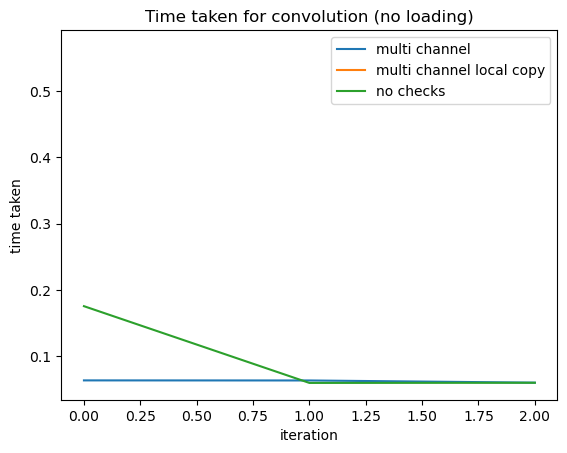

In [48]:
# Performance test
import matplotlib.pyplot as plt

time_taken_convolution_multi_channel_local_copy, output = test_convolution(load_image(), kernel, n=1,
                                                                           func=convolve_multi_channel)

time_taken_convolution_multi_channel, _ = test_convolution(load_image(), kernel, n=3, func=convolve_multi_channel)

time_taken_convolution_no_checks, _ = test_convolution(load_image(), kernel, n=3, func=convolve_no_checks)

plt.plot(time_taken_convolution_multi_channel, label='multi channel')
plt.plot(time_taken_convolution_multi_channel_local_copy, label='multi channel local copy')
plt.plot(time_taken_convolution_no_checks, label='no checks')
plt.xlabel('iteration')
plt.ylabel('time taken')
plt.legend()

plt.title('Time taken for convolution (no loading)')

plt.show()






In [50]:
# Kernel size and gaussian sigma test
kernel_sizes = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21,32, 64, 128, 256]
sigmas = [1, 5, 10, 20, 50, 100, 200]

SAVE_LOCATION = DATA_PATH / 'kernel_tests'

SAVE_LOCATION.mkdir(exist_ok=True)
for i, kernel_size in enumerate(kernel_sizes):
    for j, sigma in enumerate(sigmas):
        kernel = gkern(kernel_size, sigma)
        output = test_convolution(load_image(), kernel, n=1, func=convolve_multi_channel)[1]
        # save the output
        output = Image.fromarray(output.astype(np.uint8))
        output.save(SAVE_LOCATION / f'output_{kernel_size}_{sigma}.jpg')

In [25]:
# grayscale

@cuda.jit
def grayscale(result, image):
    # expects a 2D grid and 2D blocks,
    # a RGB image with 3 channels.

    # (-2-) 2D coordinates of the current thread:
    i, j = cuda.grid(2)

    # (-3-) if the thread coordinates are outside of the image, we ignore the thread:
    image_rows, image_cols, _ = image.shape
    if (i >= image_rows) or (j >= image_cols):
        return

    # (-4-) initialize the result for the current pixel:
    result[i, j] = 0

    # (-5-) iterate over the mask:
    for c in range(image.shape[2]):
        result[i, j] += image[i, j][c] / 3

In [180]:
# create output array
output = np.zeros(img.shape[:2], dtype=np.float32)

# create a cuda device array
d_input = cuda.to_device(img, stream)
d_output = cuda.to_device(output, stream)

# create a grid
threadsperblock = (16, 16)
blockspergrid_x = (img.shape[0] + threadsperblock[0] - 1) // threadsperblock[0]
blockspergrid_y = (img.shape[1] + threadsperblock[1] - 1) // threadsperblock[1]
blockspergrid = (blockspergrid_x, blockspergrid_y)

# run the kernel
grayscale[blockspergrid, threadsperblock, stream](d_output, d_input)

# stream the output back to the host
d_output.copy_to_host(output, stream=stream)
stream.synchronize()


In [181]:
# display the output
output = Image.fromarray(output)
output.show()

In [29]:
# do edge detection with sobel filter
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

sobel_y = np.array([[-1, -2, -1],
                    [0, 0, 0],
                    [1, 2, 1]])

scharr = np.array([[-3, 0, 3],
                   [-10, 0, 10],
                   [-3, 0, 3]])
# create output array
output_x = np.zeros_like(img)
output_y = np.zeros_like(img)
output_scharr = np.zeros_like(img)

# create a cuda device array
d_input = cuda.to_device(img, stream)
d_output_x = cuda.to_device(output_x, stream)
d_output_y = cuda.to_device(output_y, stream)
d_output_scharr = cuda.to_device(output_scharr, stream)
d_sobel_x = cuda.to_device(sobel_x, stream)
d_sobel_y = cuda.to_device(sobel_y, stream)
d_scharr = cuda.to_device(scharr, stream)

# run the kernel
convolve[blockspergrid, threadsperblock, stream](d_output_x, d_sobel_x, d_input)
convolve[blockspergrid, threadsperblock, stream](d_output_y, d_sobel_y, d_input)
convolve[blockspergrid, threadsperblock, stream](d_output_scharr, d_scharr, d_input)

# copy the output back to the host
d_output_x.copy_to_host(output_x, stream=stream)
d_output_y.copy_to_host(output_y, stream=stream)
d_output_scharr.copy_to_host(output_scharr, stream=stream)

"""
Ixy=sqrt(Ix^2+Iy^2)
"""
output = np.sqrt(output_x ** 2 + output_y ** 2)




TypingError: Failed in cuda mode pipeline (step: nopython frontend)
[1m[1m('wrong tuple length for $18load_attr.8: ', 'expected 2, got 3')[0m
[0m[1mDuring: typing of exhaust iter at C:\Users\appad\AppData\Local\Temp\ipykernel_36620\955992347.py (14)[0m
[1m
File "C:\Users\appad\AppData\Local\Temp\ipykernel_36620\955992347.py", line 14:[0m
[1mdef convolve(result, mask, image):
    <source elided>
    # (-3-) if the thread coordinates are outside of the image, we ignore the thread:
[1m    image_rows, image_cols = image.shape
[0m    [1m^[0m[0m


In [ ]:
# display the output
output = Image.fromarray(output_y)
output.show()